In [439]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import matplotlib.cm as cm
warnings.filterwarnings('ignore')

%matplotlib inline

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs
plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
sns.set(style="whitegrid") # seteando tipo de grid en seaborn
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [440]:
cleaned_reviews = pd.read_csv("/content/drive/MyDrive/tp1- orga de datos/Datos clientes/cleaned-reviews.csv", parse_dates = ["date"])
costumer_data= pd.read_csv("/content/drive/MyDrive/tp1- orga de datos/Datos clientes/customer_airways_data.csv",encoding="iso-8859-1")

costumer_data = costumer_data.drop_duplicates()
costumer_data["sales_channel"] = costumer_data["sales_channel"].astype("category")
costumer_data["trip_type"] = costumer_data["trip_type"].astype("category")
costumer_data["flight_day"] = costumer_data["flight_day"].astype("category")


# *Hipotesis 2: Cuáles son las rutas más elegidas? ¿De qué nacionalidad son los viajeros que las toman? ¿Existe alguna relación con los puntajes de estos países?*

In [441]:
informacion_de_compra = costumer_data[["route", "trip_type", "sales_channel", "booking_complete", "purchase_lead", "booking_origin"]]
informacion_de_compra = informacion_de_compra.rename(columns={"booking_origin": "country"})
fecha_de_viaje = cleaned_reviews[["date", "verified","country"]]
informacion_de_vuelo = pd.merge(informacion_de_compra, fecha_de_viaje, how = "outer")

In [442]:
informacion_de_vuelo = informacion_de_vuelo.dropna()
vuelos_validos = informacion_de_vuelo.loc[(informacion_de_vuelo.booking_complete == 1) & (informacion_de_vuelo.verified == True)]
paises_y_rutas = vuelos_validos.groupby(["country", "route"]).agg(cant_viajeros_ruta = ('route', 'count')).reset_index()

In [443]:
vuelos_preferidos = paises_y_rutas.sort_values(["cant_viajeros_ruta"],ascending=False).reset_index()
indice_rutas_elegidas_pais = vuelos_preferidos.groupby('country')['cant_viajeros_ruta'].idxmax()
ruta_mas_elegida_pais = vuelos_preferidos.loc[indice_rutas_elegidas_pais]
ruta_mas_elegida_pais = ruta_mas_elegida_pais.sort_values("cant_viajeros_ruta", ascending= False)
ruta_mas_elegida_pais = ruta_mas_elegida_pais.iloc[:,1:]


In [444]:
top_10_rutas = ruta_mas_elegida_pais.head(10)
top_10_rutas = top_10_rutas[["country","route","cant_viajeros_ruta"]]
rutas_elegidas = top_10_rutas.pivot(index="country",columns="route",values="cant_viajeros_ruta").fillna(0).reset_index()
def mapear_paises(serie):
  traduccion = {"Thailand":"Tailandia","South Korea":"Corea del Sur","Malaysia":"Malasia","Singapore":"Singapur","United States":"Estados Unidos","United Kingdom":"Reino Unido","China":"China","Hong Kong":"Hong Kong","Taiwan":"Taiwan","Australia":"Australia","Tailandia":"Tailandia"}
  return traduccion[serie]
rutas_elegidas["country"] = rutas_elegidas["country"].map(mapear_paises)
rutas_elegidas.set_index("country",inplace = True)

In [445]:
rutas_elegidas["total"] = rutas_elegidas.sum(axis=1)
rutas_elegidas = rutas_elegidas.sort_values("total",ascending =True)
rutas_elegidas = rutas_elegidas.drop(columns="total")
rutas_elegidas_ordenadas = rutas_elegidas.sum().sort_values(ascending=False)
rutas_elegidas_ordenadas = rutas_elegidas[rutas_elegidas_ordenadas.index]


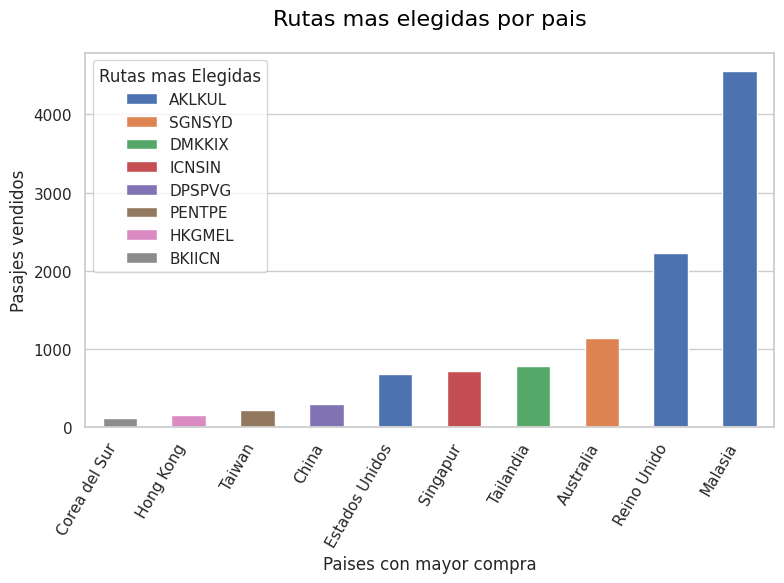

In [446]:
sns.set_palette("deep",n_colors=8)
rutas_elegidas_ordenadas.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.xlabel('Paises con mayor compra')
plt.ylabel('Pasajes vendidos')
plt.title('Rutas mas elegidas por pais', fontsize=16, color='Black', loc='center', pad=20)
ejes = plt.gca()
ejes.set_xticklabels(rutas_elegidas_ordenadas.index, rotation=60, ha='right')
plt.legend(title='Rutas mas Elegidas')
plt.tight_layout()
plt.gca().yaxis.grid(True)
plt.gca().xaxis.grid(False)
plt.show()

# 3 **¿Cómo afecta el medio de compra de pasajes a los puntajes de los clientes en los diez países con el mayor volumen de compra?**

In [447]:
info_pasaje = costumer_data[["booking_complete","num_passengers","length_of_stay","flight_hour","flight_day","booking_origin","sales_channel"]]
filtro = ((info_pasaje["booking_origin"] != "(not set)") & (info_pasaje["booking_complete"] == 1))

info_pasaje = info_pasaje[filtro]
info_pasaje = info_pasaje.iloc[:,1:]
datos_de_pasajeros = info_pasaje[["num_passengers","sales_channel","booking_origin"]]

In [448]:
medio_de_compras = datos_de_pasajeros.sales_channel.value_counts()
medio_de_compras = medio_de_compras.to_frame()
medio_de_compras.reset_index(inplace = True)
medio_de_compras.columns = ["medio de compra", "ventas totales"]

def traducir(serie):
  if(serie =="Mobile"):
    return "Celular"
  return serie

medio_de_compras["medio de compra"] = medio_de_compras["medio de compra"].map(traducir)

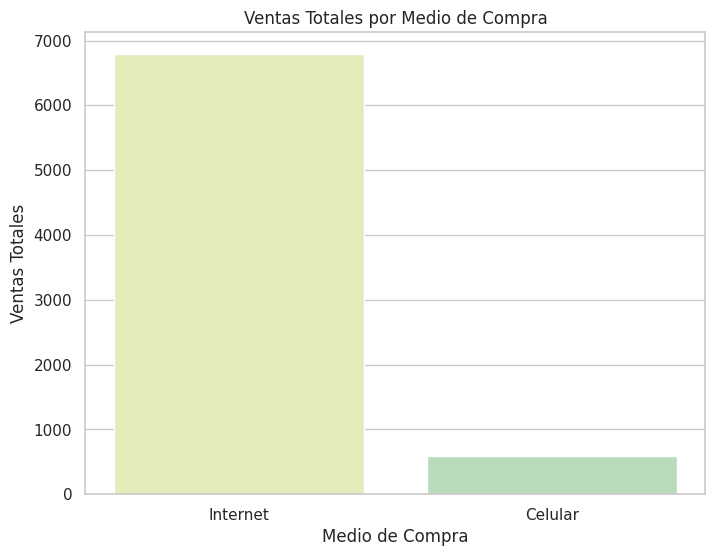

In [449]:
paleta_colores = ["#E3EDBA","#B8DBBB"]
plt.figure(figsize=(8, 6))
plt.bar(medio_de_compras["medio de compra"], medio_de_compras["ventas totales"], color = paleta_colores)

plt.xlabel("Medio de Compra")
plt.ylabel("Ventas Totales")
plt.title("Ventas Totales por Medio de Compra")
plt.gca().yaxis.grid(True)
plt.gca().xaxis.grid(False)
plt.show()

In [450]:
promedio_pasajeros = datos_de_pasajeros.groupby(["booking_origin","sales_channel"])[["num_passengers"]].mean().fillna(0).reset_index()
promedio_pasajeros = promedio_pasajeros.rename(columns={"num_passengers": "average_passengers","booking_origin": "country"})
promedio_pasajeros = promedio_pasajeros.merge(top_10_rutas[["country"]],on="country",how="right")

promedio_pasajeros["sales_channel"] = promedio_pasajeros.sales_channel.map(traducir)
promedio_pasajeros = promedio_pasajeros.sort_values("average_passengers",ascending = False)
promedio_pasajeros["country"] = promedio_pasajeros["country"].map(mapear_paises)

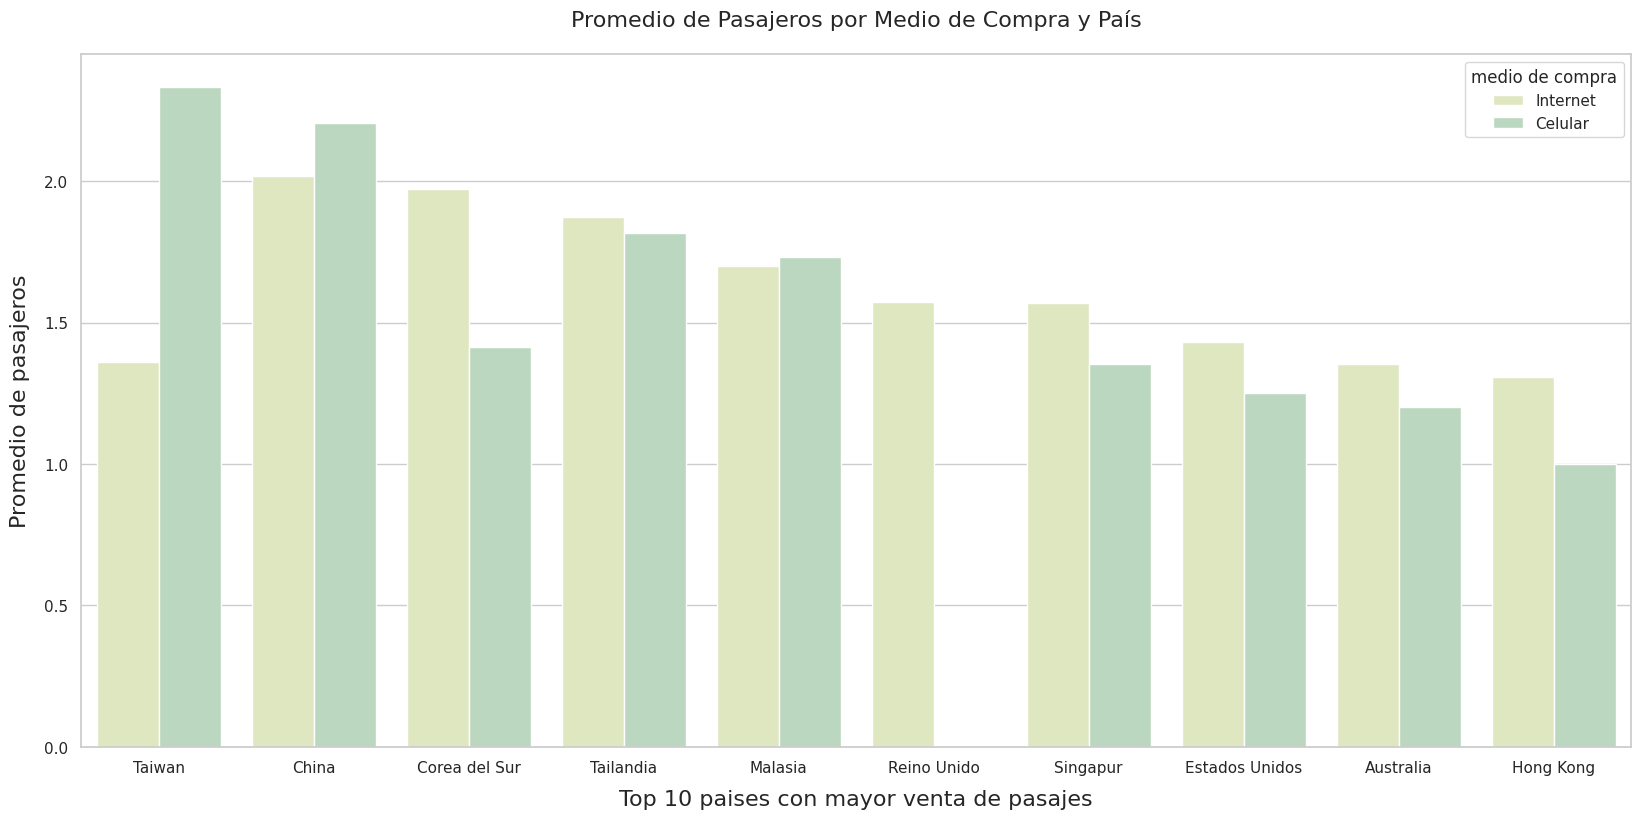

In [451]:
plt.figure(figsize = (20, 9))
sns.barplot(x = "country", y = "average_passengers", hue = "sales_channel", data=promedio_pasajeros,palette = paleta_colores)
plt.title("Promedio de Pasajeros por Medio de Compra y País",pad = 20,fontsize = 16)
plt.xlabel("Top 10 paises con mayor venta de pasajes",fontsize = 16,labelpad = 10)
plt.ylabel("Promedio de pasajeros",fontsize = 16,labelpad = 10)
plt.legend(title = "medio de compra")

# 4 **¿Cómo afectan los días y horas de vuelo a la satisfacción de los viajeros en los países con un alto volumen de compra de pasajes?**

In [452]:
dias_de_viaje = info_pasaje.groupby(["flight_day","flight_hour"])[["num_passengers"]].sum().reset_index()
dias_de_viaje = dias_de_viaje.groupby(["flight_day","flight_hour"])[["num_passengers"]].sum().reset_index()

dias = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]

def dias_traduccion(serie):
  traduccion = {"Mon":dias[0],"Tue":dias[1],"Wed":dias[2],"Thu":dias[3],"Fri":dias[4],"Sat":dias[5],"Sun":dias[6]}
  return traduccion[serie]

dias_de_viaje["flight_day"] = dias_de_viaje["flight_day"].map(dias_traduccion)
dias_de_viaje['flight_day'] = pd.Categorical(dias_de_viaje['flight_day'], categories=dias, ordered=True)
pasajeros_por_dia = dias_de_viaje.groupby("flight_day")[["num_passengers"]].sum().reset_index()

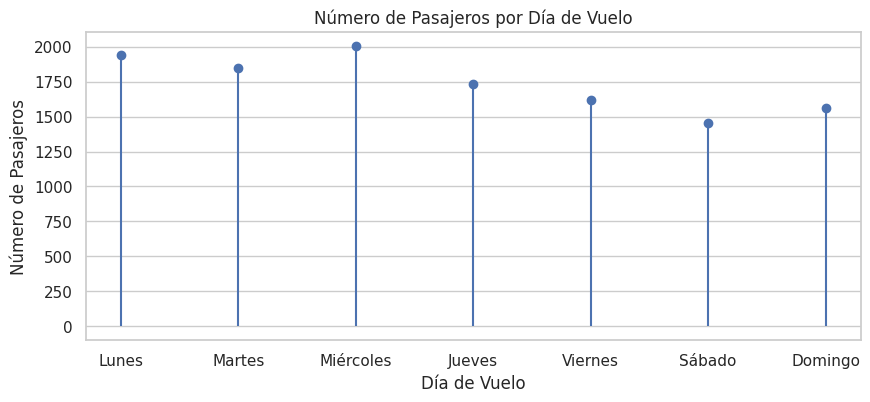

In [453]:
plt.figure(figsize=(10, 4))
plt.stem(pasajeros_por_dia["flight_day"], pasajeros_por_dia["num_passengers"], linefmt="b-", markerfmt="bo", basefmt=" ")
plt.title("Número de Pasajeros por Día de Vuelo")
plt.xlabel("Día de Vuelo")
plt.ylabel("Número de Pasajeros")
plt.grid(True)
plt.gca().yaxis.grid(True)
plt.gca().xaxis.grid(False)
plt.show()

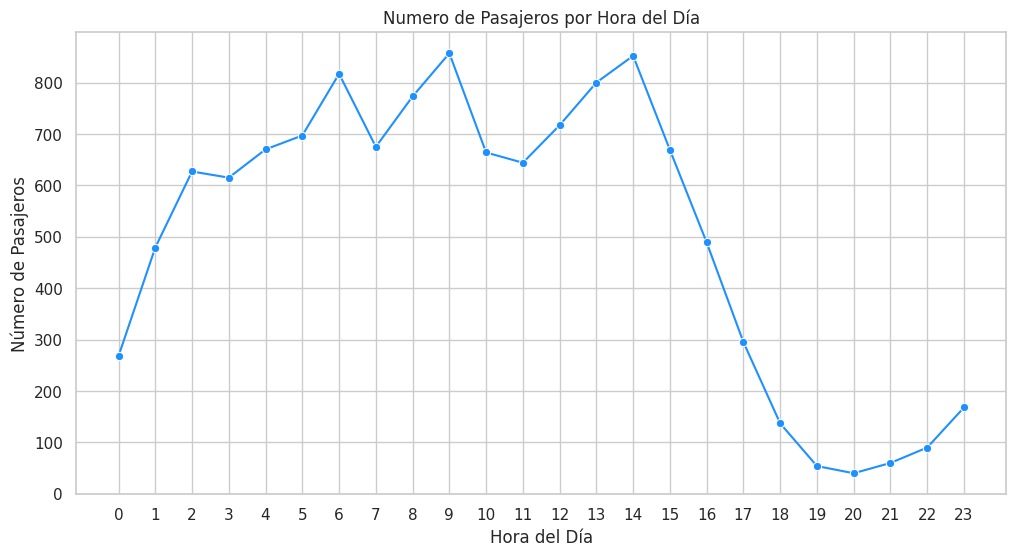

In [454]:
pasajeros_por_hora = dias_de_viaje.groupby("flight_hour")[["num_passengers"]].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x="flight_hour", y="num_passengers", data=pasajeros_por_hora, marker="o", color = "dodgerblue")
plt.xlabel("Hora del Día")
plt.ylabel("Número de Pasajeros")
plt.title("Numero de Pasajeros por Hora del Día")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

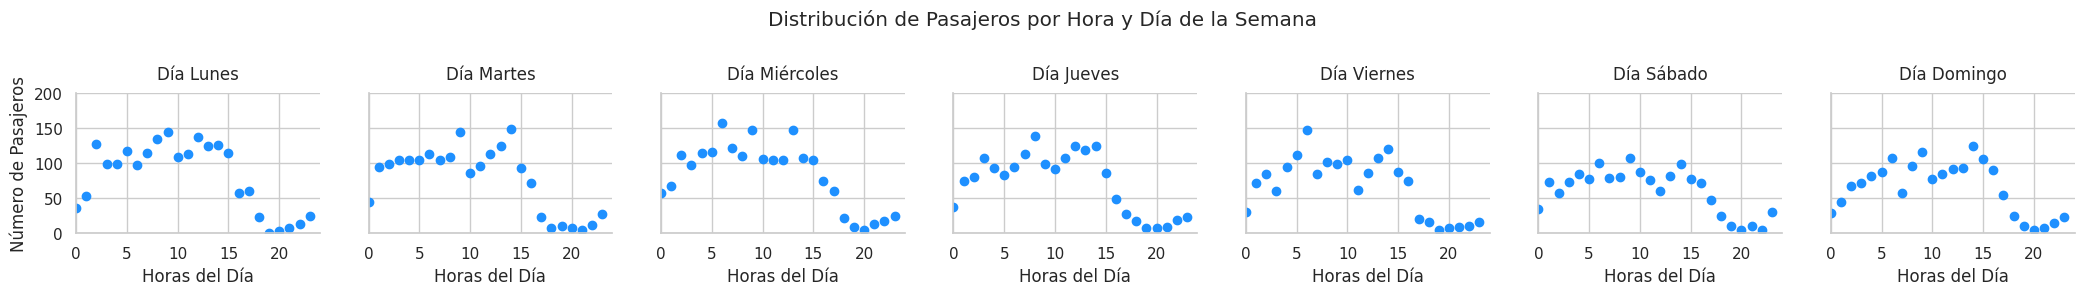

In [455]:
distribucion_psaajeros = sns.FacetGrid(dias_de_viaje, col="flight_day")
distribucion_psaajeros = distribucion_psaajeros.map(plt.scatter, "flight_hour", "num_passengers", color= 'dodgerblue').set_titles("Día {col_name}",pad=10)
distribucion_psaajeros.set_axis_labels("Horas del Día", "Número de Pasajeros")
plt.subplots_adjust(top=0.7)

plt.ylim(0,200)
plt.xlim(0,24)
distribucion_psaajeros.fig.subplots_adjust(wspace=0.2, hspace=1)
distribucion_psaajeros.fig.suptitle('Distribución de Pasajeros por Hora y Día de la Semana')
plt.show()

# 5 **¿ El motivo del viaje, determinado por la época del año y el destino, en los puntajes de los clientes de la aerolínea?**

In [456]:
info_de_vuelos = vuelos_validos[["route","date","country","purchase_lead"]]
info_de_vuelos["origen"] = info_de_vuelos["route"].str.slice(0, 3)
info_de_vuelos["destino"] = info_de_vuelos["route"].str.slice(3)
info_de_vuelos.drop(columns=["route"], inplace=True)
info_de_vuelos["purchase_lead"] = pd.to_timedelta(info_de_vuelos["purchase_lead"], unit="D")
info_de_vuelos["vuelo"] = info_de_vuelos["date"] + info_de_vuelos["purchase_lead"]

In [457]:
def mes_a_trimestre(fecha):
  if 1 <= fecha.month <= 3:
    return 1
  elif 4 <= fecha.month <= 6:
    return 2
  elif 7 <= fecha.month <= 9:
    return 3
  else:
    return 4

info_de_vuelos.vuelo = info_de_vuelos.vuelo.map(mes_a_trimestre)
info_de_vuelos = info_de_vuelos.rename(columns={"vuelo": "trimestre"})

In [458]:
trimestres = info_de_vuelos.groupby("trimestre")["destino"].value_counts()
trimestres = trimestres.to_frame()
trimestres.columns = ["cantidad de personas"]
trimestres.reset_index(inplace = True)
cantidad_por_destino = trimestres.groupby(["trimestre", "destino"])["cantidad de personas"].sum().reset_index()
top5_por_cuatrimestre = cantidad_por_destino.groupby("trimestre").apply(lambda x: x.nlargest(5, "cantidad de personas")).reset_index(drop=True)
top5_por_cuatrimestre = top5_por_cuatrimestre.pivot(index = "destino",columns = "trimestre",values ="cantidad de personas").fillna(0)
top5_por_cuatrimestre["total_visitas"] = top5_por_cuatrimestre.sum(axis=1)

In [459]:
ranking_ordenado = top5_por_cuatrimestre.sort_values(by="total_visitas", ascending=False)
ranking_ordenado.drop(columns=["total_visitas"], inplace=True)
ranking_ordenado.index = ["Australia(OOL)","Taiwan(TPE)","Australia(MEL)","Malasia(PEN)","Australia(PER)","Malasia(KUL)","Australia(SYD)"]

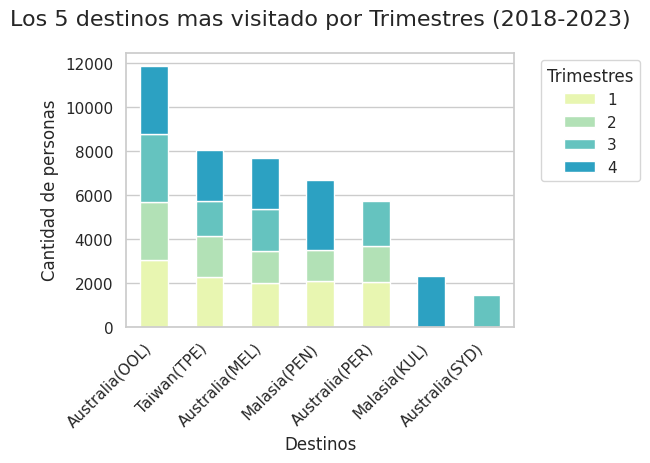

In [460]:
sns.set_palette("YlGnBu")
ranking_ordenado.plot(kind="bar", stacked=True)
plt.xlabel("Destinos")
plt.ylabel("Cantidad de personas")
plt.title("Los 5 destinos mas visitado por Trimestres (2018-2023)",fontsize = 16,pad = 20)
plt.legend(title = "Trimestres", bbox_to_anchor = (1.05, 1), loc = "upper left")
plt.xticks(range(len(ranking_ordenado.index)), ranking_ordenado.index, rotation=45, ha="right")
plt.tight_layout()
plt.grid(True)
plt.gca().yaxis.grid(True)
plt.gca().xaxis.grid(False)
plt.show()

#6 **¿La verificación y la duración de los vuelos tiene algun impacto en la satisfacción de los clientes en los países con mayor compra de pasajes?,**


In [461]:
datos_vuelo = costumer_data.loc[:,["booking_origin", "flight_duration","booking_complete"]]
datos_vuelo = datos_vuelo.rename(columns = {"booking_origin": "country"})
filtro = datos_vuelo["booking_complete"] == 1
datos_vuelo = datos_vuelo[filtro]
reviews = cleaned_reviews.loc[:,["verified", "rates","country"]]

In [462]:
informacion_viaje = reviews.merge(datos_vuelo, how = "outer")
informacion_viaje["verified"] = informacion_viaje["verified"].astype(bool)

informacion_viaje = informacion_viaje.groupby(['country', 'verified']).agg({"rates":"mean", "flight_duration": "mean"}).reset_index().dropna()
informacion_viaje = informacion_viaje.rename(columns = {"flight_duration": "promedio_horas_vuelo", "rates": "promedio_puntaje"})
informacion_viaje = informacion_viaje.merge(top_10_rutas, how="right", on="country")
informacion_viaje = informacion_viaje.iloc[:,:4]

vuelos_verificados = (informacion_viaje.loc[informacion_viaje["verified"] == True])
vuelos_no_verificados = (informacion_viaje.loc[informacion_viaje["verified"] == False])


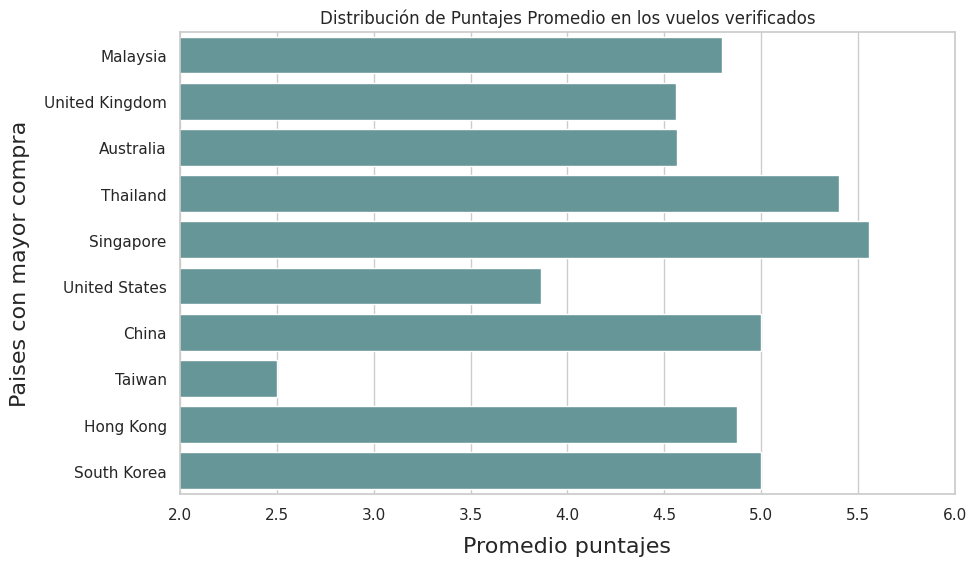

In [463]:
plt.figure(figsize = (10, 6))
sns.barplot(data = vuelos_verificados, x = "promedio_puntaje", y = "country", color="CadetBlue")
plt.title("Distribución de Puntajes Promedio en los vuelos verificados")
plt.ylabel("Paises con mayor compra",fontsize = 16,labelpad = 10)
plt.xlabel("Promedio puntajes",fontsize = 16,labelpad = 10)
plt.xlim(2,6)
plt.show()

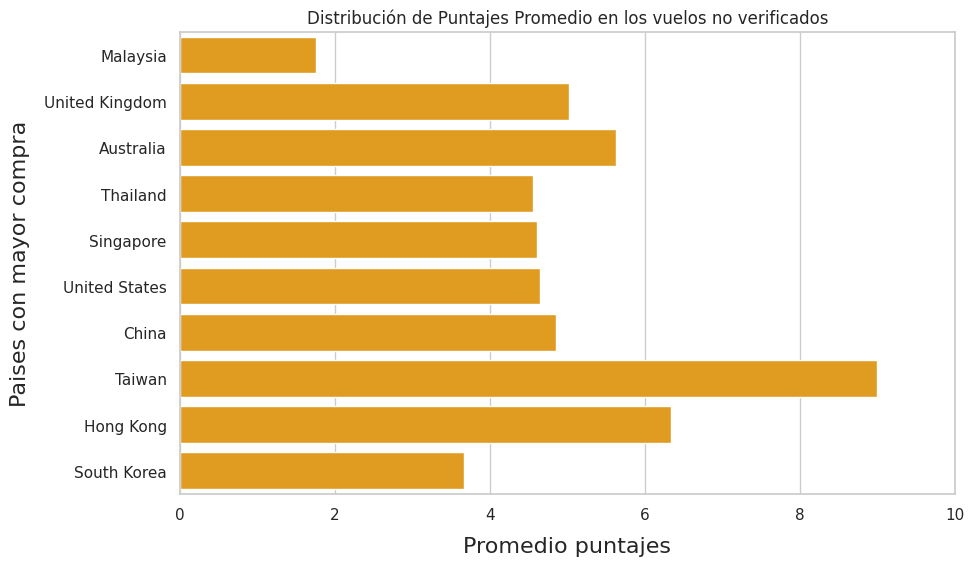

In [464]:
plt.figure(figsize = (10, 6))
sns.barplot(data = vuelos_no_verificados, x = "promedio_puntaje", y = "country", color = "orange")
plt.title("Distribución de Puntajes Promedio en los vuelos no verificados")
plt.ylabel("Paises con mayor compra",fontsize = 16,labelpad = 10)
plt.xlabel("Promedio puntajes",fontsize = 16,labelpad = 10)
plt.xlim(0,10)
plt.show()

In [465]:
estadisticas_verificados = vuelos_verificados["promedio_horas_vuelo"].describe()
estadisticas_no_verificados = vuelos_no_verificados["promedio_horas_vuelo"].describe()


primer_cuartil = estadisticas_verificados["25%"]
mediana = estadisticas_verificados["50%"]
tercer_cuartil = estadisticas_verificados["75%"]
valores_rango = ["Alto","Medio","Bajo","Muy bajo"]
def categorizar_estadisticas(valor):
    if valor <= primer_cuartil:
        return valores_rango[3]
    elif valor > primer_cuartil and valor <= mediana:
        return valores_rango[2]
    elif valor > mediana and valor <= tercer_cuartil:
        return valores_rango[1]
    else:
        return valores_rango[0]

vuelos_verificados["rango_horas_vuelo"] = vuelos_verificados["promedio_horas_vuelo"].map(categorizar_estadisticas)

primer_cuartil = estadisticas_no_verificados["25%"]
mediana = estadisticas_no_verificados["50%"]
tercer_cuartil = estadisticas_no_verificados["75%"]
vuelos_no_verificados["rango_horas_vuelo"] = vuelos_no_verificados["promedio_horas_vuelo"].map(categorizar_estadisticas)

In [466]:
vuelos_verificados["country"] = vuelos_verificados["country"].map(mapear_paises)
vuelos_no_verificados["country"] = vuelos_no_verificados["country"].map(mapear_paises)

vuelos_verificados["rango_horas_vuelo"] = pd.Categorical(vuelos_verificados["rango_horas_vuelo"], categories=valores_rango, ordered=True)
vuelos_no_verificados["rango_horas_vuelo"] = pd.Categorical(vuelos_verificados["rango_horas_vuelo"], categories=valores_rango, ordered=True)

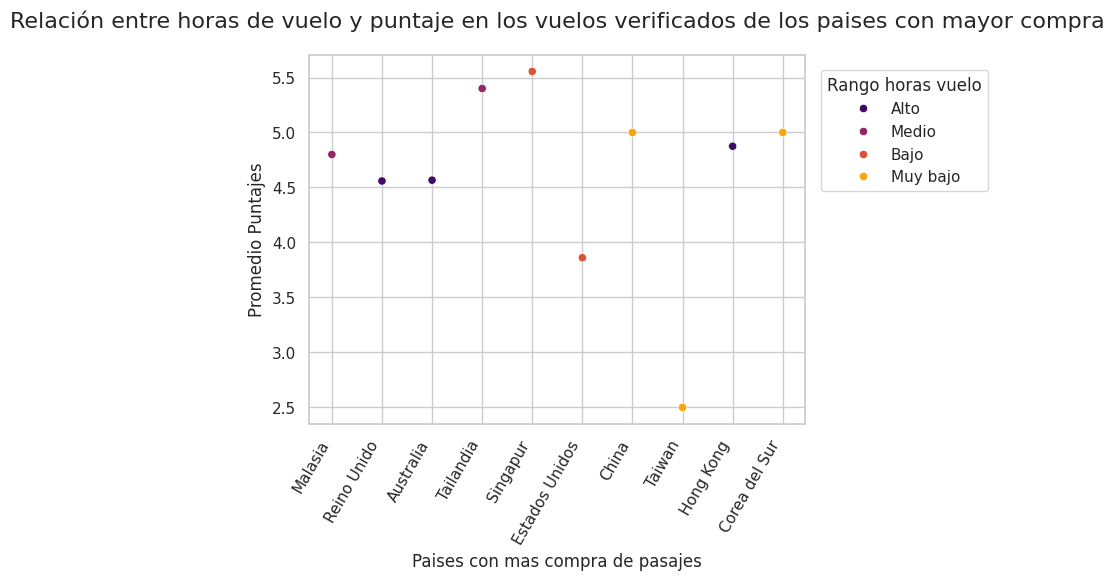

In [467]:
paleta_de_colores = sns.color_palette("inferno", 4)
sns.scatterplot(y = "promedio_puntaje",x = "country", hue = "rango_horas_vuelo", data = vuelos_verificados,palette = paleta_de_colores)
plt.title("Relación entre horas de vuelo y puntaje en los vuelos verificados de los paises con mayor compra",pad = 20,fontsize = 16)
plt.ylabel("Promedio Puntajes")
plt.xlabel("Paises con mas compra de pasajes")
plt.legend(title="Rango horas vuelo", loc = "upper left", bbox_to_anchor = (1, 1), borderaxespad = 1)
ejes = plt.gca()
ejes.set_xticklabels(vuelos_verificados["country"], rotation=60, ha='right')
plt.show()

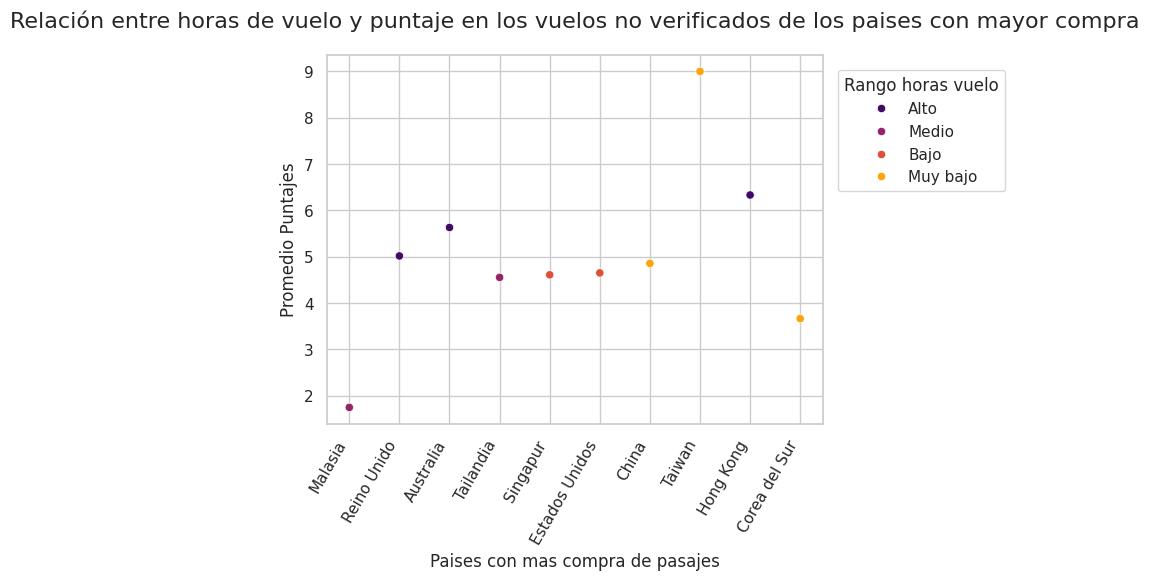

In [468]:
paleta_de_colores = sns.color_palette("inferno", 4)
sns.scatterplot(y = "promedio_puntaje",x = "country", hue = "rango_horas_vuelo", data = vuelos_no_verificados,palette = paleta_de_colores)
plt.title("Relación entre horas de vuelo y puntaje en los vuelos no verificados de los paises con mayor compra",pad = 20,fontsize = 16)
plt.ylabel("Promedio Puntajes")
plt.xlabel("Paises con mas compra de pasajes")
plt.legend(title="Rango horas vuelo", loc = "upper left", bbox_to_anchor = (1, 1), borderaxespad = 1)
ejes = plt.gca()
ejes.set_xticklabels(vuelos_no_verificados["country"], rotation=60, ha="right")
plt.show()

# 7 **Ver de agregar algo de NLP, utilizando por ejemplo las reviews del DS.**

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('vader_lexicon')

In [470]:
satisfaccion_cliente = cleaned_reviews[["reviews","country", "verified"]]
satisfaccion_cliente = satisfaccion_cliente.loc[satisfaccion_cliente.verified == 1]
satisfaccion_cliente = satisfaccion_cliente.merge(top_10_rutas, how="right", on="country")
satisfaccion_cliente["country"] = satisfaccion_cliente["country"].map(mapear_paises)
satisfaccion_cliente = satisfaccion_cliente[["reviews","country"]]

In [471]:
opiniones = satisfaccion_cliente["reviews"].astype(str)
opiniones = opiniones.map(lambda x: re.sub(r"[^\w\s]", "", x))
opiniones = opiniones.map(lambda x: x.lower())
opiniones = opiniones.map(lambda x: word_tokenize(x))

In [474]:
#usamos esto xq nos permite cubrir todas las variaciones de los comentarios positivos y/o negativos, esto no sucede si utilizamos expresiones regulares ya que nos vemos limitados por el conocimiento nuestro
sentimientos = SentimentIntensityAnalyzer()
def analisis_de_sentimientos(reviews):
  review_texto = " ".join(reviews)
  puntaje = sentimientos.polarity_scores(review_texto) #diccionario con todos los puntajes
  if puntaje["pos"] > puntaje["neg"]:
    return 1
  elif puntaje["neg"] > puntaje["pos"]:
    return 0
  return -1

satisfaccion_cliente["sentimiento"] = satisfaccion_cliente["reviews"].map(analisis_de_sentimientos)
satisfaccion_cliente = satisfaccion_cliente.loc[satisfaccion_cliente.sentimiento != -1]

In [485]:
sentimiento_paises = satisfaccion_cliente.groupby("country").agg({"sentimiento":"mean"})
sentimiento_paises = sentimiento_paises.sort_values("sentimiento", ascending=False)

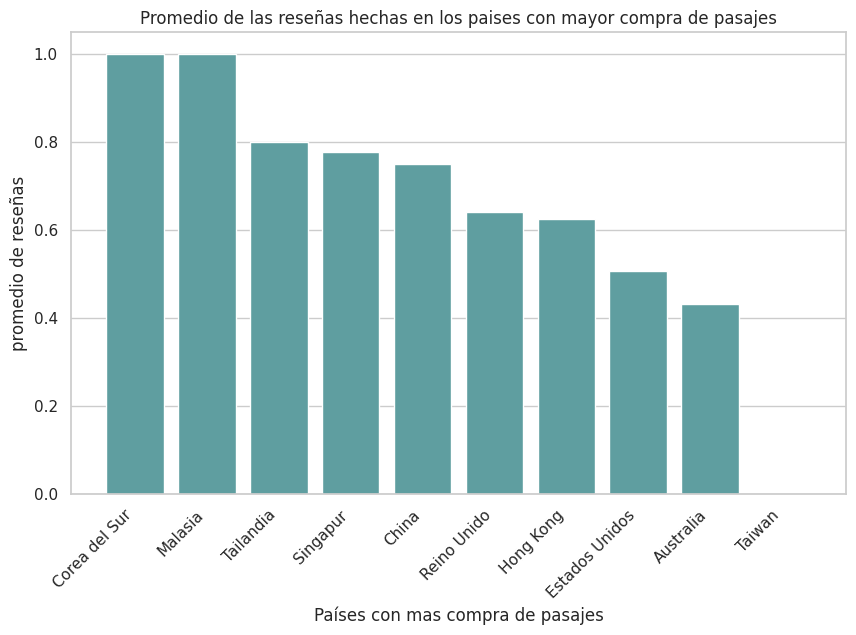

In [486]:
plt.figure(figsize=(10, 6))
plt.bar(sentimiento_paises.index, sentimiento_paises["sentimiento"], color="CadetBlue")
plt.xlabel("Países con mas compra de pasajes")
plt.ylabel("promedio de reseñas")
plt.title("Promedio de las reseñas hechas en los paises con mayor compra de pasajes")
plt.xticks(rotation=45, ha="right")
plt.grid(True)
plt.gca().yaxis.grid(True)
plt.gca().xaxis.grid(False)
plt.show()

#raro por que malasya y south korea tenian puntajes bajos
#taiwan estaba en al categoria medio y no se ve reflejado en las reseñas ya que solo presenta reseñas catalogadas como negativas

#conclusion -> los clientes son mas criticos en las reseñas que en las reviews -> sugiere que las reseñas estan mas atadas a experiencias en el viaje q en la aerolinea???

In [484]:
satisfaccion_cliente

,reviews,country,sentimiento
0,"[trip, verified, check, shamble, bwi, 3, count...",Malasia,1
1,"[trip, verified, evening, flight, lhr, iad, a3...",Malasia,1
2,"[trip, verified, doha, london, surprisingly, g...",Malasia,1
3,"[trip, verified, long, time, avoided, taking, ...",Malasia,1
4,"[trip, verified, edinburgh, kuala, lumpur, via...",Malasia,1
5,"[trip, verified, kuala, lumpur, miami, via, lo...",Malasia,1
6,"[trip, verified, kuala, lumpur, mexico, city, ...",Malasia,1
7,"[trip, verified, ba34, kullhr, 6, sept, return...",Malasia,1
8,"[trip, verified, 13, hour, flight, heathrow, k...",Malasia,1
9,"[trip, verified, kuala, lumpur, madrid, via, l...",Malasia,1


In [ ]:
#- Malasia (Bajo)
#- Reino Unido (Medio)
#- Australia(Alto)
#- Tailandia (Medio)
#- Singapur (Medio)
#- Estados Unidos (Bajo)
#- China: (Medio)
#- Taiwán (Medio)
#- Hong Kong: (Alto)
#- Corea del Sur(Bajo)